# Example 3: Simulating SKS splitting

In this example we generate core-refracted teleseismic shear waves (e.g., SKS, SKKS) to examine the effect of shear wave splitting through anisotropic media. See the model file for details. 

Start by importing the necessary modules

In [1]:
import numpy as np
from obspy.core import Stream
from obspy.signal.rotate import rotate_ne_rt
from telewavesim import utils as ut
from telewavesim import wiggle as wg

Select the model file:

In [2]:
modfile = '../models/model_SKS.txt'

Select the type of incident wave - options are `'P'`, `'SV'`, `'SH'`, or `'Si'`, which is an isotropic S-wave source. SKS waves are SV polarized, so select `'SV'`.

<div class="alert alert-info">
  <strong>Info!</strong> Note that you could select 'P' and examine long-period P-wave polarization! In this case you should consider plotting the 3 Z-R-T components - there is yet no plotting script to do that though.
</div>

In [3]:
wvtype = 'SV'

Next we use variables to define the desired time series.

<div class="alert alert-warning">
  <strong>Warning!</strong> Be careful to use a total length of time large enough to avoid wrap around effects. Sometimes if you see signals arriving at aberrant (early) times, try with either (or both) a greater number of samples or higher sample distance.
</div>

In [4]:
npts = 3000 # Number of samples
dt = 0.05   # Sample distance in seconds

Now specify the parameters of the incident wavefield in terms of a horizontal slowness and back-azimuth. In this example the slowness won't change, so we can pass it as a global variable now. The back-azimuth will range from 0 to 360 degrees with a 10-degree increment, so we define a `np.ndarray` for this variable and do not yet pass it as a global variable.

In [5]:
slow = 0.04 # Horizontal slowness (or ray parameter) in s/km 
baz = np.arange(0., 360., 10.)

Read the model parameters from the model file and return Model object. Up to here, the steps could have been performed in no particular order, except the name of the file that needs to be defined before the call to `read_model()`

In [6]:
model = ut.read_model(modfile)

The following step is useful for plotting the plane wave seismograms with respect to the predicted propagation time through the model (from lowermost interface up to the seafloor). Since we are doing SKS wave modeling, we are interested in plane wave seismograms so let's calculate it.

In [7]:
t1 = ut.calc_ttime(model, slow, wvtype=wvtype)
print('Predicted propagation time from model: {0:4.1f} sec'.format(t1))

Predicted propagation time from model: 21.6 sec


As we need to loop through back-azimuth values, we will initialize empty `Stream` objects to store the traces from the output of the main routine. 

In [8]:
trR = Stream(); trT = Stream()

Now the main loop over back-azimuths where all calculations are done - self explanatory

In [9]:
# Loop over range of data 
for bb in baz:

    # Calculate the plane wave seismograms
    trxyz = ut.run_plane(model, slow, npts, dt, bb, wvtype=wvtype)

    # Extract East, North and Vertical
    ntr = trxyz[0]
    etr = trxyz[1]
    ztr = trxyz[2]

    # Copy to radial and transverse
    rtr = ntr.copy()
    ttr = etr.copy()

    # Rotate to radial and transverse
    rtr.data, ttr.data = rotate_ne_rt(ntr.data, etr.data, bb)

    # Append to streams
    trR.append(rtr)
    trT.append(ttr)

The result of the previous loop is a set of radial and transverse seismograms. We simply filter the `Stream` objects using some frequency corners to simulate the frequency content of SKS waves

In [10]:
# Set frequency corners in Hz
f1 = 0.01
f2 = 0.2

# Filter to get wave-like traces
trR.filter('bandpass',freqmin=f1, freqmax=f2, corners=2, zerophase=True)
trT.filter('bandpass',freqmin=f1, freqmax=f2, corners=2, zerophase=True)

36 Trace(s) in Stream:

... | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:02:29.950000Z | 20.0 Hz, 3000 samples
...
(34 other traces)
...
... | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:02:29.950000Z | 20.0 Hz, 3000 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]


Plotting Wiggles by baz


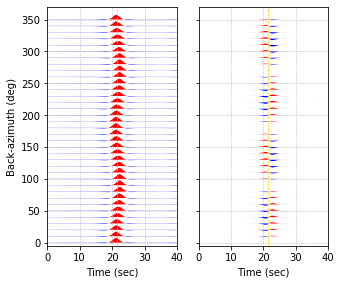

In [11]:
# Plot as wiggles
wg.pw_wiggles_baz(trR, trT, 'test', btyp='baz', scale=0.05,
                  t1=t1, tmin=0., tmax=40, save=False,
                  ftitle='sks', wvtype='SV')

And Voilà! 

Can you find the fast direction and approximate delay time? Easy from the plot of radial components. Null measurements are also quite obvious from the absence of signal on the transverse component at back-azimtuths corresponding to the fast and slow axes. In this example the anisotropic layer is defined by hexagonal symmetry with a fast axis and 10% anisotropy. You can play with the model to have two anisotropic layers with different fast axis orientations, or use anisotropic elastic tensors determined in the lab (e.g., use `'ol'` (abbreviation for 'olivine') instead of `'tri'` in the definition of the layer in the model file). Enjoy!